# Sentiment Analysis and Topic Modeling on Contact Reports

Project Summary:
- Created two models that perform sentiment analysis on contact reports to predict the interaction as positive, neutral, or negative using NLP packages VADER and TextBlob. 
- Created logistic regression models on sentiment scores to predict sentiment of future contact reports.
- Visualized the text data accordingly to respective sentiment with wordclouds.
- Performed topic modeling on negative contact reports to understand the themes and areas of concern.

### Data source

The data was sourced from Kaggle.

A 196 row sample constituent data set with contact reports from the book: Data Science for Fundraising.

Pawlus, M. Fundraising Data, Version 1. Retrieved December 18, 2022 from https://www.kaggle.com/datasets/michaelpawlus/fundraising-data?select=data_science_for_fundraising_contact_reports.csv.


#### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def compound_score(txt):
    return sid.polarity_scores(txt)["compound"]

import re
import string
from wordcloud import WordCloud,STOPWORDS

###Using Tfidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# build a classifier 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
import scikitplot as skplt

#testing another library
from textblob import TextBlob


# Import the lemmatizer from nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
from nltk.corpus import stopwords

import gensim
from gensim import corpora
import pyLDAvis.gensim_models


C:\Users\dsemi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dsemi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dsemi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Import dataset

In [2]:
df = pd.read_csv("data_science_for_fundraising_contact_reports.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Staff Name   196 non-null    object
 1   Method       196 non-null    object
 2   Date         196 non-null    object
 3   Summary      196 non-null    object
 4   Substantive  196 non-null    object
 5   Donor        196 non-null    object
 6   Outcome      196 non-null    object
dtypes: object(7)
memory usage: 10.8+ KB


#### Clean the data

In [3]:
#check for duplicates
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [4]:
# chekcing for missing data
nan_cols = df.loc[:,df.isna().any(axis=0)]
nan_cols

""
0
1
2
3
4
...
191
192
193
194


In [5]:
#review data
df.head()

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome
0,Ann Marie Levier,Email,12/1/17,Sent Dominic an email asking for an update if ...,Y,Dominic Richards,Positive
1,Ann Marie Levier,Email,12/1/17,"Emailed Dr. Jonathan Winters, who have ties to...",Y,William Bendrich,Positive
2,Ann Marie Levier,Letter,11/30/17,"Sent Belinda an upgrade brochure, appeal lette...",Y,Belinda Carlyle,Positive
3,Deborah Mettier,Phone,11/29/17,$50k to extend Kendrick Memorial Undergraduate...,Y,Donna Gilbert,Positive
4,Ann Marie Levier,Letter,11/27/17,Sent upgrade brochure asking Jeffrey and Julie...,Y,Jeffrey Jantz,Positive


In [6]:
#take a look at the labeled data field
df['Outcome'].value_counts()

Negative    133
Positive     63
Name: Outcome, dtype: int64

The data above shows Outcome as the labeled sentiment score and that there are 133 negative contact reports and 63 positive contact reports.

#### Adding sentiment scores using VADER's SentimentIntensityAnalyzer

Although we have labeled data here, using a sentiment analyzer can help label future contact reports. Manually labeling sentiment scores for each contact report is not always possible so building a model that can predict this is helpful to glean insight from unlabeled reports.

In [7]:
df['score']= df['Summary'].apply(lambda Summary:
sid.polarity_scores(Summary))

df.head()

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome,score
0,Ann Marie Levier,Email,12/1/17,Sent Dominic an email asking for an update if ...,Y,Dominic Richards,Positive,"{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp..."
1,Ann Marie Levier,Email,12/1/17,"Emailed Dr. Jonathan Winters, who have ties to...",Y,William Bendrich,Positive,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp..."
2,Ann Marie Levier,Letter,11/30/17,"Sent Belinda an upgrade brochure, appeal lette...",Y,Belinda Carlyle,Positive,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp..."
3,Deborah Mettier,Phone,11/29/17,$50k to extend Kendrick Memorial Undergraduate...,Y,Donna Gilbert,Positive,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp..."
4,Ann Marie Levier,Letter,11/27/17,Sent upgrade brochure asking Jeffrey and Julie...,Y,Jeffrey Jantz,Positive,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou..."


In [8]:
df['compound'] = df['Summary'].astype("str").apply(compound_score)
df.head(2)

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome,score,compound
0,Ann Marie Levier,Email,12/1/17,Sent Dominic an email asking for an update if ...,Y,Dominic Richards,Positive,"{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...",0.8910
1,Ann Marie Levier,Email,12/1/17,"Emailed Dr. Jonathan Winters, who have ties to...",Y,William Bendrich,Positive,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",0.8481


In [9]:
## deining the compound score to respective sentiment
def sentiment(compound):
    emotion=""
    if compound >=0.5:
        emotion="Positive"
    elif compound <= -0.5:
        emotion= "Negative"
    else:
        emotion= "Neutral"
    return emotion

In [10]:
df['Sentiment'] = df['compound'].apply(sentiment)
df.tail()

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome,score,compound,Sentiment
191,Rashi Mohinder,Visit,8/27/17,Definitely interested in the University and wo...,N,Ben Johnson,Positive,"{'neg': 0.0, 'neu': 0.503, 'pos': 0.497, 'comp...",0.7845,Positive
192,Rashi Mohinder,Email,8/27/17,not interested in the University,N,Adam Panda,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral
193,April Catson,Visit,8/27/17,not interested in the University,N,Billy Gross,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral
194,April Catson,Phone,8/27/17,not interested in the University,N,Carrie Booker,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral
195,April Catson,Visit,8/27/17,Definitely interested in the University and wo...,N,Dori Keller,Positive,"{'neg': 0.0, 'neu': 0.503, 'pos': 0.497, 'comp...",0.7845,Positive


#### Now that a new sentiment label has been created, this can be compared to the actual outcome.

C:\Users\dsemi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dsemi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Distribution of Interaction by Label')

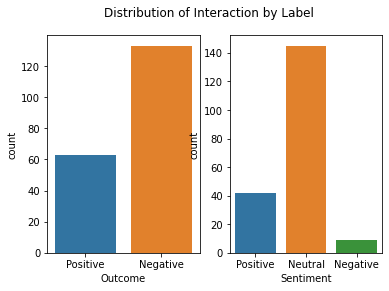

In [11]:
fig, ax=plt.subplots(1,2)
sns.countplot(df['Outcome'], ax=ax[0])
sns.countplot(df['Sentiment'], ax=ax[1])
plt.suptitle('Distribution of Interaction by Label')

The new sentiment label has an additional neutral sentiment which is different than the original labeled data. The new model reduced the number of negative contact reports significantly. Next steps should be to review this for accuracy.

In [12]:
Neutral = df.loc[df['Sentiment'] == "Neutral"]
Neutral

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome,score,compound,Sentiment
3,Deborah Mettier,Phone,11/29/17,$50k to extend Kendrick Memorial Undergraduate...,Y,Donna Gilbert,Positive,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp...",0.4215,Neutral
5,Ann Marie Levier,Letter,11/24/17,Sent Marsha an leadership annual fund upgrade ...,Y,Marsha Kenmore,Positive,"{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'comp...",0.4404,Neutral
8,Carlos Bendiga,Email,10/30/17,Not available during next trip to Seattle. Dec...,N,Barbara Benaldi,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
9,Ann Marie Levier,Email,10/27/17,Emailed about continued funding or guidance re...,N,Jeff Zink,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
10,Ann Marie Levier,Email,10/27/17,Laurie is not able to meet now (too busy),N,Laurie Stickel,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
...,...,...,...,...,...,...,...,...,...,...
189,Deborah Mettier,Phone,8/27/17,not interested in the University,N,Steve Pinchas,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral
190,Rashi Mohinder,Email,8/27/17,not interested in the University,N,Bill Mendez,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral
192,Rashi Mohinder,Email,8/27/17,not interested in the University,N,Adam Panda,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral
193,April Catson,Visit,8/27/17,not interested in the University,N,Billy Gross,Negative,"{'neg': 0.361, 'neu': 0.639, 'pos': 0.0, 'comp...",-0.3089,Neutral


Isolating the neutral reports from the sentiment score, let's compare the relationship between the outcome label and the new sentiment label and see how it performed.

Text(0.5, 1.08, 'Sentiment by Compound Score Vs. Outcome Label')

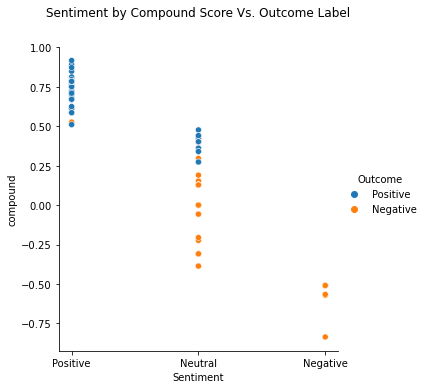

In [13]:
sns.relplot(x='Sentiment', y ="compound", hue="Outcome", data=df)
plt.title('Sentiment by Compound Score Vs. Outcome Label', y=1.08)

Because a new sentiment label was created, some positive and negative sentiment labels will be categorized as neutral inevitably. The model does seem to be able to capture the positives and negatives correctly. 

Perhaps it is worthwhile to lower the threshold so that more positive labeled outcome reports are put into the positive sentiment label and vice versa. Let's review the reports that the outcome labeled as negative but sentiment model labeled as neutral. 

In [14]:
#reviewing negative outcome with compound higher than .20
O_N = df.loc[df['Outcome'] == "Negative"]
O_N = O_N.loc[O_N['compound'] >0]
O_N.head()

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome,score,compound,Sentiment
19,Rashi Mohinder,Email,10/1/17,Ken's no longer wishes to support the universi...,N,Ken Takahashi,Negative,"{'neg': 0.207, 'neu': 0.496, 'pos': 0.298, 'co...",0.2960,Neutral
23,Ann Marie Levier,Email,9/27/17,Follow-up email after not being able to connec...,N,Leonard Palmer,Negative,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp...",0.1531,Neutral
56,Deborah Mettier,Phone,7/18/17,Miriam declined visit and is no longer interes...,N,Miriam Weathers,Negative,"{'neg': 0.158, 'neu': 0.647, 'pos': 0.194, 'co...",0.1280,Neutral
71,Rashi Mohinder,Phone,7/15/17,Bondo declined to support Research project fun...,N,Bondo Beadry,Negative,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",0.4019,Neutral
72,Rashi Mohinder,Email,7/15/17,Billy declined to support Research project fun...,N,Billy Blanks,Negative,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",0.4019,Neutral


These reports do seem to be negative.

Reviewing the entire breakout of the compound score to see the frequency distribution of the compound scores.

Text(0.5, 1.0, 'Distribution of Compound Score')

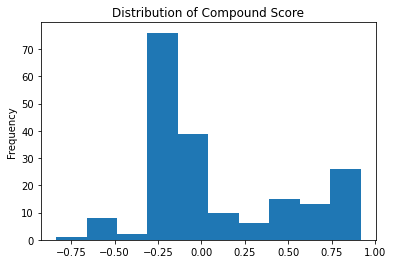

In [15]:
#taking a look at the compound score to see the distribution
df['compound'].plot.hist(bins=10)
plt.title('Distribution of Compound Score')

Most reports are slightly lower than a true neutral at 0. This indicates that although the outcome label marks these as negative, the SentimentInsentityAnalyzer compound score is not severly neagtive.

## Building classification models for sentiment

#### Transform contact reports to vector for classification model.

In [16]:
#vectorize text data
nltkstop_words = stopwords.words('english')
nltkstop_words = list(nltkstop_words)
nltkstop_words = nltkstop_words.extend(['university', 'student', 'next', 'meeting', 'month', 'discuss', 'prospect', 'message'])
vect = TfidfVectorizer(stop_words=nltkstop_words, max_features=200, token_pattern=r'\b[^d\W][^\d\W]+\b').fit(df.Summary)
X=vect.transform(df['Summary'])

report_transformed = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
print('Top 5 rows of the DF: \n', report_transformed.head())

Top 5 rows of the DF: 
    able     about  adam  after  again  agreed  also  amy        an       and  \
0   0.0  0.000000   0.0    0.0    0.0     0.0   0.0  0.0  0.392951  0.000000   
1   0.0  0.000000   0.0    0.0    0.0     0.0   0.0  0.0  0.000000  0.000000   
2   0.0  0.000000   0.0    0.0    0.0     0.0   0.0  0.0  0.224230  0.124760   
3   0.0  0.000000   0.0    0.0    0.0     0.0   0.0  0.0  0.000000  0.250338   
4   0.0  0.181294   0.0    0.0    0.0     0.0   0.0  0.0  0.000000  0.215548   

   ...  weeks      well       who  will  wishes      with     would  yamamoto  \
0  ...    0.0  0.000000  0.000000   0.0     0.0  0.261361  0.135833       0.0   
1  ...    0.0  0.000000  0.295091   0.0     0.0  0.000000  0.000000       0.0   
2  ...    0.0  0.244473  0.000000   0.0     0.0  0.149141  0.000000       0.0   
3  ...    0.0  0.000000  0.000000   0.0     0.0  0.000000  0.000000       0.0   
4  ...    0.0  0.000000  0.000000   0.0     0.0  0.000000  0.000000       0.0   

   yani 

#### Base Model using Outcome

Accuracy on the test set: 0.864406779661017


Text(0.5, 1.0, 'Confusion matrix from Outcome')

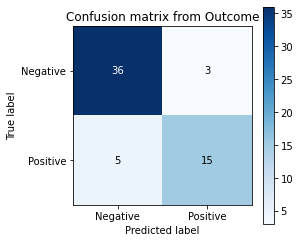

In [17]:
y = df['Outcome']
X = report_transformed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression().fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)

print('Accuracy on the test set:', accuracy_score(y_test, y_predicted))
skplt.metrics.plot_confusion_matrix(y_test, y_predicted, figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix from Outcome')

In [18]:
print("Classification Report for Outcome:\n",classification_report(y_test, y_predicted))

Classification Report for Outcome:
               precision    recall  f1-score   support

    Negative       0.88      0.92      0.90        39
    Positive       0.83      0.75      0.79        20

    accuracy                           0.86        59
   macro avg       0.86      0.84      0.84        59
weighted avg       0.86      0.86      0.86        59



Building a logistic regression from the outcome label shows an overall average of 86% accuracy. This indicated that using outcome as the actual target, the model can learn from the contact reports and be 86% accurate. More importantly, the precision and recall for negative contact reports are high. However, the positive recall is only 75%, meaning out of the 20 sample positive contact reports, it was only able to identify 75% of them as positive, mistaking 5 of these reports as negative. 

Accuracy on the test set: 0.864406779661017


Text(0.5, 1.0, 'Confusion matrix from Sentiment')

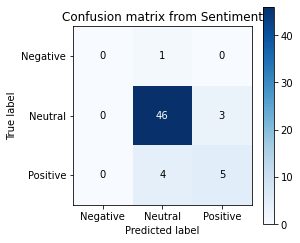

In [19]:
y = df['Sentiment']
X = report_transformed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg_sent = LogisticRegression().fit(X_train, y_train)
y_predicted_sent = log_reg_sent.predict(X_test)

print('Accuracy on the test set:', accuracy_score(y_test, y_predicted_sent))
skplt.metrics.plot_confusion_matrix(y_test, y_predicted_sent, figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix from Sentiment')

In [20]:
print("Classification Report for Sentiment:\n",classification_report(y_test, y_predicted_sent))

Classification Report for Sentiment:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.90      0.94      0.92        49
    Positive       0.62      0.56      0.59         9

    accuracy                           0.86        59
   macro avg       0.51      0.50      0.50        59
weighted avg       0.84      0.86      0.85        59



C:\Users\dsemi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dsemi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dsemi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Building a logistic regression from the sentiment label shows an overall average of 86% accuracy, the same as the outcome label. However, the precision and recall for negative contact reports 0. This means that using Sentiment labels, our model was unable to identify and predict any negative contact reports. This is because the sentiment distribution has very few labeled negative contact reports. Most reports it identified as neutral. Here the logistic regression model performed much better with precision and recall over 90%.

### Tuning Sentiment

Redefining the sentiment score here to see if a new classifier performs better.

In [21]:
#tuning the scores to 0.2 to see if it will increase the accuracy score
##sentiment
def sentiment2(compound):
    emotion=""
    if compound >=0.3:
        emotion="Positive"
    elif compound <= -0.3:
        emotion= "Negative"
    else:
        emotion= "Neutral"
    return emotion

In [22]:
df['Sentiment2'] = df['compound'].apply(sentiment2)

C:\Users\dsemi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dsemi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Distribution of Sentiment by Label')

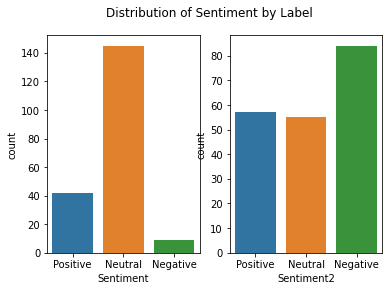

In [23]:
fig, ax=plt.subplots(1,2)
sns.countplot(df['Sentiment'], ax=ax[0])
sns.countplot(df['Sentiment2'], ax=ax[1])
plt.suptitle('Distribution of Sentiment by Label')

The new Sentiment2 distribution of classes seems more similar to the Outcome labels and is more meaningful than having majority of the reports as neutral.

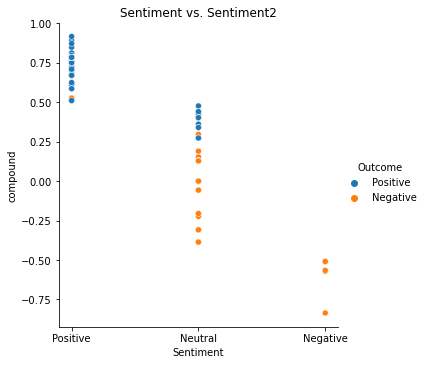

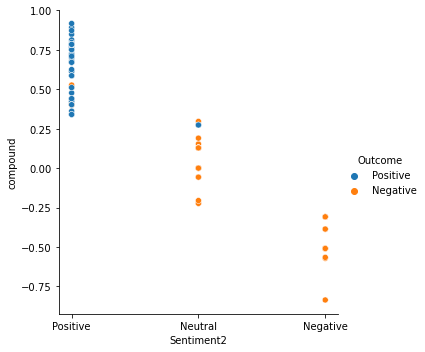

In [24]:
#Comparing sentiment and revised sentiment2 with outcome
sns.relplot(x='Sentiment', y ="compound", hue="Outcome", data=df)
plt.title('Sentiment vs. Sentiment2')
sns.relplot(x='Sentiment2', y ="compound", hue="Outcome", data=df)


Sentiment2 captures more positive and negative reports than Sentiment which is expected given the changes in the compound score for these labels.

# Sentiment 2 Model

Accuracy on the test set: 0.8305084745762712


Text(0.5, 1.0, 'Confusion matrix of Sentiment2')

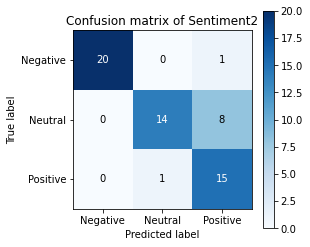

In [25]:
y = df['Sentiment2']
X = report_transformed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg_sent2 = LogisticRegression().fit(X_train, y_train)
y_predicted2_sent2 = log_reg_sent2.predict(X_test)

print('Accuracy on the test set:', accuracy_score(y_test, y_predicted2_sent2))
skplt.metrics.plot_confusion_matrix(y_test, y_predicted2_sent2, figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix of Sentiment2')

In [26]:
print("Classification Report for Sentiment2:\n",classification_report(y_test, y_predicted2_sent2))

Classification Report for Sentiment2:
               precision    recall  f1-score   support

    Negative       1.00      0.95      0.98        21
     Neutral       0.93      0.64      0.76        22
    Positive       0.62      0.94      0.75        16

    accuracy                           0.83        59
   macro avg       0.85      0.84      0.83        59
weighted avg       0.87      0.83      0.83        59



While the overall accuracy of Sentiment2 is 83% compared to 86% of Sentiment1, Sentiment2 is a much better label for our logistic regression model to learn from with 95%+ on precision and recall on negative reports. The positive precision is lower at 62% meaning out of the 16 positive contact reports in the sample test set, it thought 8 additional reports were positive when they were negative or neutral. If we look closer at the confusion matrix, the classification model mistakenly believed 8 neutral reports were positive. This can be evaluated for business implications but a neutral vs positive interaction is not a big cost of outreach compared to believing a negative interaction was positive.

#### Evaluating all models

Comparing the metrics for the logistic regression model using Outcome, Sentiment, or Sentiment2 label shows that the overall accuracy is tied between Outcome and Sentiment but that Sentiment has no recall of negative reports. This could mean that the negative reports are missed entirely and misclassified. Sentiment2, however, has a perfect precision score for negative reports but a lower overall recall.

In this project, negative contact reports are valuable for topic modeling so Sentiment2 model is favored.

### Build TextBlob Model

TextBlob: TextBlob is a Python library that offers a simple API for sentiment analysis. It uses a Naive Bayes classifier to classify text as positive, negative, or neutral.

In [27]:
#testing another library
#from textblob import TextBlob

def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df['textblob_Subjectivity'] = df['Summary'].apply(getSubjectivity)
df['textblob_Polarity'] = df['Summary'].apply(getPolarity)

def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [28]:
df['textblob_analysis'] = df['textblob_Polarity'].apply(getAnalysis)
df.head()

,Staff Name,Method,Date,Summary,Substantive,Donor,Outcome,score,compound,Sentiment,Sentiment2,textblob_Subjectivity,textblob_Polarity,textblob_analysis
0,Ann Marie Levier,Email,12/1/17,Sent Dominic an email asking for an update if ...,Y,Dominic Richards,Positive,"{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...",0.8910,Positive,Positive,0.775,0.425,Positive
1,Ann Marie Levier,Email,12/1/17,"Emailed Dr. Jonathan Winters, who have ties to...",Y,William Bendrich,Positive,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",0.8481,Positive,Positive,0.000,0.000,Neutral
2,Ann Marie Levier,Letter,11/30/17,"Sent Belinda an upgrade brochure, appeal lette...",Y,Belinda Carlyle,Positive,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.6124,Positive,Positive,0.000,0.000,Neutral
3,Deborah Mettier,Phone,11/29/17,$50k to extend Kendrick Memorial Undergraduate...,Y,Donna Gilbert,Positive,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp...",0.4215,Neutral,Positive,0.000,0.000,Neutral
4,Ann Marie Levier,Letter,11/27/17,Sent upgrade brochure asking Jeffrey and Julie...,Y,Jeffrey Jantz,Positive,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",0.7650,Positive,Positive,0.750,0.650,Positive


Accuracy on the test set: 0.7966101694915254


Text(0.5, 1.0, 'Confusion matrix of Textblob')

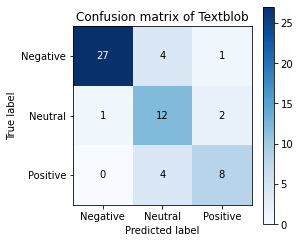

In [29]:
# build a classifier for textblob

y = df['textblob_analysis']
X = report_transformed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg_textblob = LogisticRegression().fit(X_train, y_train)
y_predicted_textblob = log_reg_textblob.predict(X_test)

print('Accuracy on the test set:', accuracy_score(y_test, y_predicted_textblob))
skplt.metrics.plot_confusion_matrix(y_test, y_predicted_textblob, figsize=(4,4), cmap="Blues")
plt.title('Confusion matrix of Textblob')

In [30]:
print("Classification Report for Textblob:\n",classification_report(y_test, y_predicted_textblob))

Classification Report for Textblob:
               precision    recall  f1-score   support

    Negative       0.96      0.84      0.90        32
     Neutral       0.60      0.80      0.69        15
    Positive       0.73      0.67      0.70        12

    accuracy                           0.80        59
   macro avg       0.76      0.77      0.76        59
weighted avg       0.82      0.80      0.80        59



TextBlob's polarity score did not outperform Sentiment2 with an overall accuracy of 80%.

### Evaluating all models for negative recall

As this project is focusing on identifying the negative contact reports correctly, we will compare all the classification model thus far for recall on negative contact reports. Recall will tell us how the model performs in retrieving the negative reports correctly. We want to find the most negative contact reports to then perform topic modeling to understand the reasons for the negative interaction.

In [31]:
#create table comparing all models
model_names = ['Base Model: Outcome','Sentiment', 'Sentiment 2', 'Textblob 3']

# create a list of recall of positive scores for each model
outcome = 0.92
sentiment = 0
sentiment2 = 0.95
textblob = 0.84

positive_recall = [outcome, sentiment, sentiment2, textblob]

# create a pandas dataframe with model names and recall scores
data = {'Model Name': model_names, 'Recall for Negative Contact Reports': positive_recall}
recall = pd.DataFrame(data)

# sort the dataframe by accuracy score in descending order
recall = recall.sort_values(by=['Recall for Negative Contact Reports'], ascending=False)

# print the dataframe
print(recall)

            Model Name  Recall for Negative Contact Reports
2          Sentiment 2                                 0.95
0  Base Model: Outcome                                 0.92
3           Textblob 3                                 0.84
1            Sentiment                                 0.00


# Sentiment over time

In [32]:
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].apply(lambda x: x.month)
df['Year'] = df['Date'].apply(lambda x: x.year)

Text(0.5, 1.0, 'Polarity over time using TextBlob')

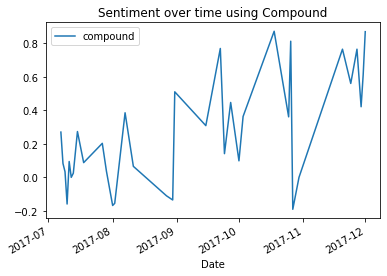

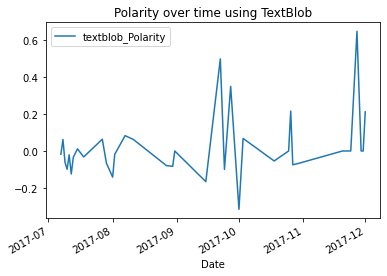

In [33]:
# Group the dataframe by date and aggregate the sentiment scores
grouped_df = df.groupby('Date')['compound'].mean().reset_index()

# Plot the sentiment scores over time using a line graph
grouped_df.plot(x='Date', y='compound')
plt.title('Sentiment over time using Compound')

# Group the dataframe by date and aggregate the sentiment scores
grouped_df = df.groupby('Date')['textblob_Polarity'].mean().reset_index()

# Plot the sentiment scores over time using a line graph
grouped_df.plot(x='Date', y='textblob_Polarity')
plt.title('Polarity over time using TextBlob')

The SentimentIntensityAnalyzer and TextBlob are two different libraries that use different approaches and models for sentiment analysis, which can lead to differences in the compound score and polarity score for the same piece of text.

The SentimentIntensityAnalyzer calculates the compound score using a lexicon-based approach, which assigns a score to each word in the text based on its sentiment and then computes a weighted sum of those scores. This approach is based on a pre-defined dictionary of words and their associated sentiment scores, and it does not take into account the context or grammar of the text.

On the other hand, TextBlob calculates the polarity score using a machine learning-based approach, which is trained on a large corpus of annotated text data. This approach takes into account the context, grammar, and structure of the text to determine the sentiment expressed in the text.

Because the two libraries use different approaches and models, their output can be different for the same piece of text. In some cases, one library may be more accurate than the other, depending on the specific application and the characteristics of the text data being analyzed.

# Word Clouds

Word clouds give a summary of the most frequently used words in the dataset. Here, the first word cloud shows all the common words from all contact reports with a bigger word appearing more frequently.

Text(0.5, 1.0, 'All Contact Reports')

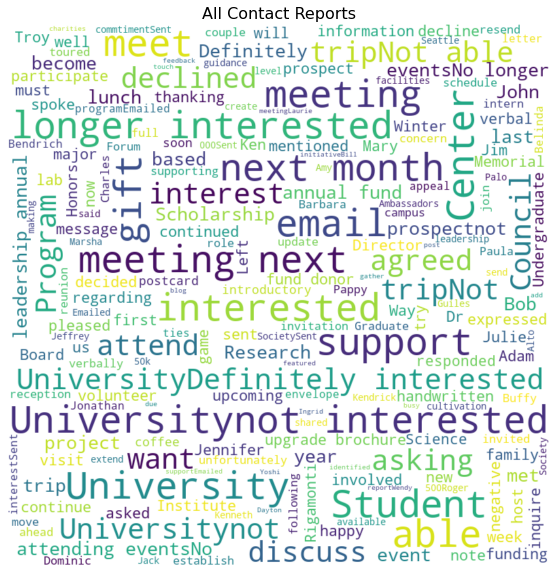

In [34]:
fig, (ax1) = plt.subplots(1,figsize=[10, 10], facecolor = None)
wc = WordCloud(width = 800, height = 800, background_color="white", min_font_size=10,
               repeat=True, stopwords = nltkstop_words)
wc.generate("". join(df['Summary'].astype(str)))
ax1.axis("off")
ax1.imshow(wc, interpolation='bilinear')
ax1.set_title('All Contact Reports', fontsize=16)

In [35]:
Positive = df.loc[df['Sentiment2'] == "Positive"]
Negative = df.loc[df['Sentiment2']== "Negative"]

Text(0.5, 1.0, 'Negative Contact Reports')

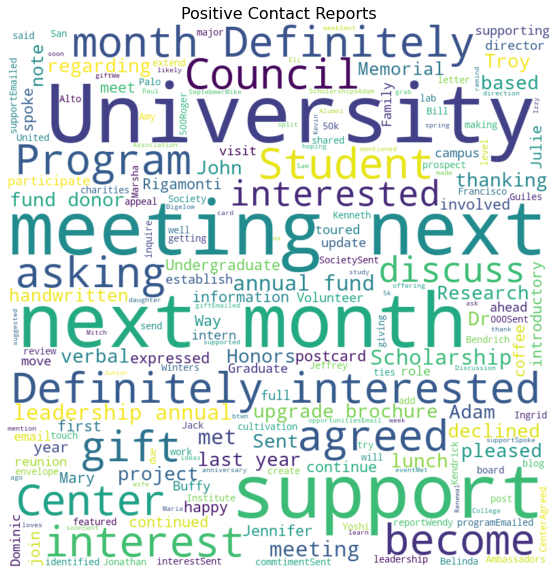

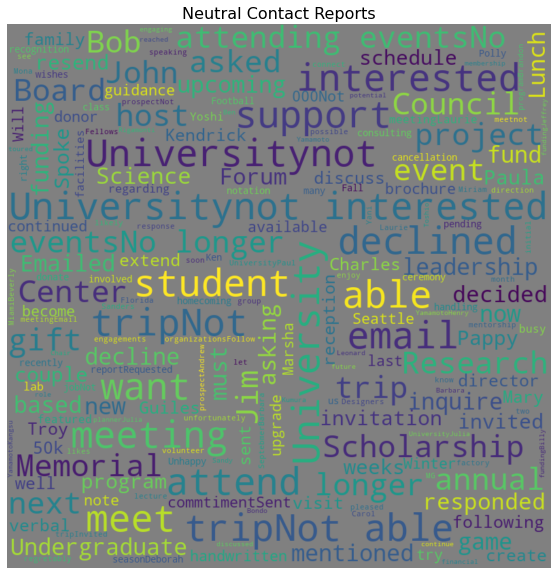

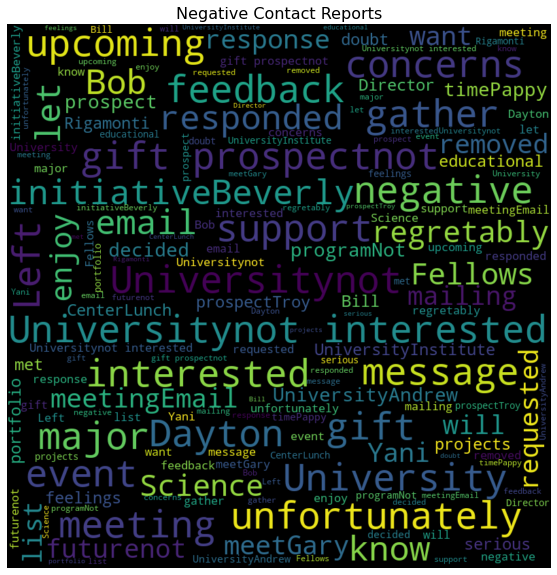

In [36]:
fig, (ax1) = plt.subplots(1,figsize=[10, 10], facecolor = None)
wc2 = WordCloud(width = 800, height = 800, background_color='white', min_font_size=10,
               repeat=True, stopwords = nltkstop_words)
wc2.generate("". join(Positive['Summary'].astype(str)))
ax1.axis("off")
ax1.imshow(wc2, interpolation='bilinear')
ax1.set_title('Positive Contact Reports', fontsize=16)

fig, (ax1) = plt.subplots(1,figsize=[10, 10], facecolor = None)
wc3 = WordCloud(width = 800, height = 800, background_color="#808080", min_font_size=10,
               repeat=True, stopwords = nltkstop_words)
wc3.generate("". join(Neutral['Summary'].astype(str)))
ax1.axis("off")
ax1.imshow(wc3, interpolation='bilinear')
ax1.set_title('Neutral Contact Reports', fontsize=16)

fig, (ax1) = plt.subplots(1,figsize=[10, 10], facecolor = None)
wc4 = WordCloud(width = 800, height = 800, background_color="black", min_font_size=10,
               repeat=True, stopwords = nltkstop_words)
wc4.generate("". join(Negative['Summary'].astype(str)))
ax1.axis("off")
ax1.imshow(wc4, interpolation='bilinear')
ax1.set_title('Negative Contact Reports', fontsize=16)

# Topic Modeling Negative Sentiment Scores

Topic modeling is a technique in natural language processing that allows for the discovery of latent topics or themes within a collection of documents. The goal of topic modeling is to automatically identify patterns of co-occurring words that suggest the presence of a particular topic or theme within a text corpus.

Topic modeling typically involves the use of unsupervised machine learning algorithms, such as Latent Dirichlet Allocation (LDA) or Non-Negative Matrix Factorization (NMF), to extract these latent topics from a collection of text documents. These algorithms use statistical methods to identify patterns of word co-occurrence and group words together into topics that are represented as probability distributions over the words in the vocabulary.

Once the topics have been extracted, they can be used for a variety of tasks such as document clustering, content recommendation, and trend analysis. Performing topic modeling on negative contact reports could help this sample organization to understand the concern of its constituents and form responses to address these concerns.

## Preprocessing text data for topic modeling

Using only negative sentiment contact reports to create the text file. To streamline this process, topic modeling will be using the Sentiment2 model to identify negative sentiment contact reports since this performed best on precision and recall.

In [37]:
neg_reports = df.loc[df['Sentiment2'] == 'Negative']
neg_reports['Sentiment2'].value_counts()

Negative    84
Name: Sentiment2, dtype: int64

In [38]:
# Import the lemmatizer from nltk
nltk.download('wordnet')
#from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

#from nltk.corpus import stopwords

new_stopwords =["university", "student", "next", "meeting", "meet","able", "trip", "month", "discuss", "prospect", "message"]
#stopwords.update(new_stopwords)
stop = set(stopwords.words('english'))
stop.update(new_stopwords)

#import string
exclude=set(string.punctuation)

# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

# Clean the emails in df and print results
text_clean=[]
for text in neg_reports['Summary']:
    text_clean.append(clean(text, stop).split())    
print(text_clean)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dsemi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['left', 'gather', 'feedback', 'dayton', 'event', 'negative', 'concern', 'upcoming', 'initiative'], ['beverly', 'responded', 'email', 'let', 'know', 'bob', 'regretably', 'enjoy', 'science', 'fellow'], ['email', 'response', 'yani', 'unfortunately', 'want'], ['gary', 'unfortunately', 'requested', 'removed', 'mailing', 'list', 'support', 'future'], ['gift'], ['interested'], ['andrew', 'decided', 'support', 'program'], ['major', 'gift', 'time'], ['pappy', 'interested', 'meeting'], ['interested'], ['interested'], ['interested'], ['interested'], ['interested'], ['institute', 'director', 'met', 'bill', 'major', 'gift'], ['troy', 'rigamonti', 'interested', 'educational', 'portfolio', 'serious', 'doubt', 'negative', 'feeling', 'center'], ['lunch', 'meeting', 'interested', 'project'], ['interested'], ['gift'], ['interested'], ['interested'], ['interested'], ['interested'], ['interested'], ['interested'], ['gift'], ['interested'], ['interested'], ['gift'], ['interested'], ['interested'], ['inter

In [39]:
dictionary = corpora.Dictionary(text_clean)
corpus = [dictionary.doc2bow(text) for text in text_clean]

print(corpus)
print(dictionary)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(11, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(20, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1)], [(31, 1)], [(29, 1), (32, 1), (33, 1), (34, 1)], [(30, 1), (35, 1), (36, 1)], [(31, 1), (37, 1), (38, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(30, 1), (35, 1), (39, 1), (40, 1), (41, 1), (42, 1)], [(7, 1), (31, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)], [(31, 1), (37, 1), (51, 1), (52, 1)], [(31, 1)], [(30, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(30, 1)], [(31, 1)], [(31, 1)], [(30, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(31, 1)], [(3

In [40]:
#define LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=5)

#save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

for topic in topics:
    print(topic)

(0, '0.717*"interested" + 0.023*"meeting" + 0.013*"bob" + 0.013*"science" + 0.013*"regretably"')
(1, '0.113*"gift" + 0.058*"interested" + 0.034*"email" + 0.034*"want" + 0.034*"response"')
(2, '0.078*"gift" + 0.076*"major" + 0.075*"time" + 0.025*"interested" + 0.016*"serious"')
(3, '0.035*"gift" + 0.034*"support" + 0.034*"unfortunately" + 0.034*"negative" + 0.034*"event"')


In [41]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)

C:\Users\dsemi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


### An interactive display showing the topics and particular words is available below when running in Jupyter notebook.

In [42]:
pyLDAvis.display(lda_display)